In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gcloud config set project project-name
!gcloud config set compute/zone us-central1-f

In [0]:
# connect drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Connect bucket and load metadata

In [0]:
from google.cloud import storage
client = storage.Client(project="kits")

In [0]:
bucket = client.get_bucket('kits_cases')

In [0]:
import json

In [0]:
blob = bucket.get_blob('kits.json')
jsonData = blob.download_as_string()
data = json.loads(jsonData)

In [0]:
len(data)

In [0]:
data[0]

{'captured_pixel_width': 0.919921875,
 'captured_slice_thickness': 1.0,
 'case_id': 'case_00000'}

# Kits19 methods

In [0]:
import argparse
import scipy.misc
import nibabel as nib
import numpy as np

def load_case(cid):
    vol = nib.load('test.nii.gz')
    seg = None #nib.load(str(case_path / "segmentation.nii.gz"))
    return vol, seg
  
  
# Constants
DEFAULT_KIDNEY_COLOR = [255, 0, 0]
DEFAULT_TUMOR_COLOR = [0, 0, 255]
DEFAULT_HU_MAX = 512
DEFAULT_HU_MIN = -512
DEFAULT_OVERLAY_ALPHA = 0.3


def hu_to_grayscale(volume, hu_min, hu_max):
    # Clip at max and min values if specified
    if hu_min is not None or hu_max is not None:
        volume = np.clip(volume, hu_min, hu_max)

    # Scale to values between 0 and 1
    mxval = np.max(volume)
    mnval = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)

    # Return values scaled to 0-255 range, but *not cast to uint8*
    # Repeat three times to make compatible with color overlay
    im_volume = 255*im_volume
    return np.stack((im_volume, im_volume, im_volume), axis=-1)


def class_to_color(segmentation, k_color, t_color):
    # initialize output to zeros
    shp = segmentation.shape
    seg_color = np.zeros((shp[0], shp[1], shp[2], 3), dtype=np.float32)

    # set output to appropriate color at each location
    seg_color[np.equal(segmentation,1)] = k_color
    seg_color[np.equal(segmentation,2)] = t_color
    return seg_color


def overlay(volume_ims, segmentation_ims, segmentation, alpha):
    # Get binary array for places where an ROI lives
    segbin = np.greater(segmentation, 0)
    repeated_segbin = np.stack((segbin, segbin, segbin), axis=-1)
    # Weighted sum where there's a value to overlay
    overlayed = np.where(
        repeated_segbin,
        np.round(alpha*segmentation_ims+(1-alpha)*volume_ims).astype(np.uint8),
        np.round(volume_ims).astype(np.uint8)
    )
    return overlayed


def visualize(cid, destination, hu_min=DEFAULT_HU_MIN, hu_max=DEFAULT_HU_MAX, 
    k_color=DEFAULT_KIDNEY_COLOR, t_color=DEFAULT_TUMOR_COLOR,
    alpha=DEFAULT_OVERLAY_ALPHA):
    # Prepare output location
    out_path = Path(destination)
    if not out_path.exists():
        out_path.mkdir()  

    # Load segmentation and volume
    vol, seg = load_case(cid)
    vol = vol.get_data()
    # seg = seg.get_data()
    # seg = seg.astype(np.int32)
    
    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol, hu_min, hu_max)
    # seg_ims = class_to_color(seg, k_color, t_color)
    
    # Overlay the segmentation colors
    # viz_ims = overlay(vol_ims, seg_ims, seg, alpha)

    # Save individual images to disk
    for i in range(vol_ims.shape[0]):
        fpath = out_path / ("{:05d}.png".format(i))
        scipy.misc.imsave(str(fpath), vol_ims[i])

# Data load tests

In [0]:
import zlib
import io
import numpy as np
from PIL import Image

In [0]:
# blob = bucket.get_blob('case_00000/imaging.nii.gz')

blob = bucket.blob('case_00000/imaging.nii.gz')
zipbytes = io.BytesIO(blob.download_as_string())

zipbytes.getbuffer().nbytes

225959599

In [0]:
# decompress

decompressor = zlib.decompressobj(16 + zlib.MAX_WBITS)
nii = decompressor.decompress(zipbytes.read())

type(nii)
len(nii)

In [0]:
import nibabel as nib
from pathlib import Path

In [0]:
blob.download_to_filename('test.nii.gz')

In [0]:
nii = nib.load('test.nii.gz')

In [0]:
vol = nii.get_data()

vol_ims = hu_to_grayscale(vol, DEFAULT_HU_MIN, DEFAULT_HU_MAX)

#for i in range(vol_ims.shape[0]):
#    fpath = out_path / ("{:05d}.png".format(i))
#    scipy.misc.imsave(str(fpath), vol_ims[i])

vol_ims.shape

(611, 512, 512, 3)

In [0]:
# matplotlib print vol_ims[300]

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.dpi'] = 150
# %matplotlib notebook



In [0]:

plt.imshow(vol_ims[500])
plt.show()

In [0]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [0]:
multi_slice_viewer(vol_ims)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>

# Mounted drive data load

In [0]:
import os
import nibabel as nib

data_path = '/content/drive/My Drive/kits_cases'
imaging_name = 'imaging.nii.gz'
segmentation_name = 'segmentation.nii.gz'

In [0]:
# example load

case = nib.load(os.path.join(data_path, 'case_00000', imaging_name))
seg = nib.load(os.path.join(data_path, 'case_00000', segmentation_name))

In [0]:
%%time
vol = case.get_data()
seg = seg.get_data()
seg = seg.astype(np.int32)

CPU times: user 6.48 s, sys: 1.72 s, total: 8.2 s
Wall time: 8.21 s


In [0]:
%%time
vol_ims = hu_to_grayscale(vol, DEFAULT_HU_MIN, DEFAULT_HU_MAX)
seg_ims = class_to_color(seg, DEFAULT_KIDNEY_COLOR, DEFAULT_TUMOR_COLOR)
viz_ims = overlay(vol_ims, seg_ims, seg, DEFAULT_OVERLAY_ALPHA)

viz_ims.shape

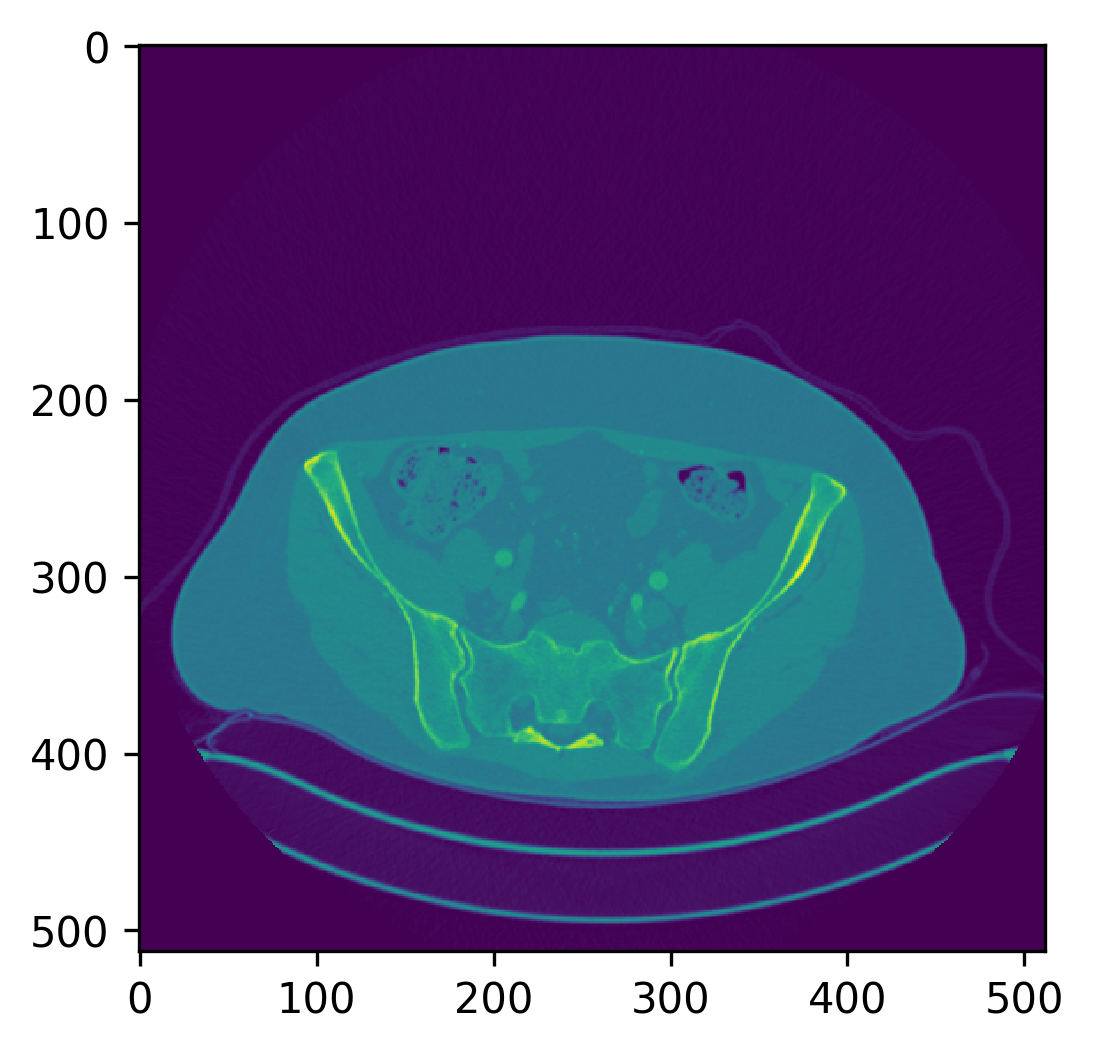

In [0]:
plt.imshow(vol[500])
plt.show()

# Create a model

In [1]:
# TODO